# Semantic segmentation using Poutyne




Semantic segmentation refers to the process of linking each pixel in an image to a class label. We can think of semantic segmentation as image classification at a pixel level. The image below clarifies the definition of semantic segmentation.
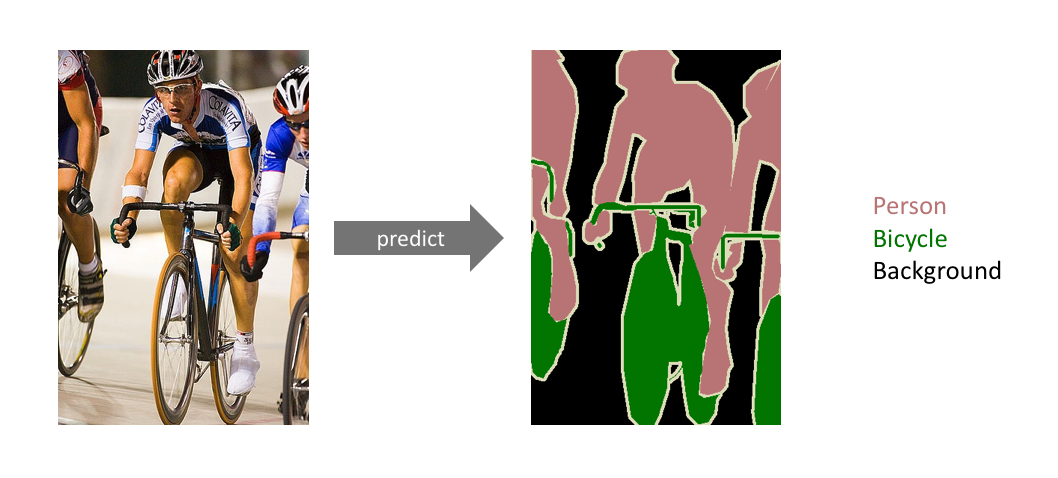

<a href="https://www.jeremyjordan.me/semantic-segmentation/"> Source</a>

In this example, we will use and train a convolutional U-Net to design a network for semantic segmentation. In other words, we formulate the task of semantic segmentation as an image translation problem. We download and use the VOCSegmentation 2007 dataset for this purpose.

In [1]:
%pip install poutyne    # Installing the Poutyne library

     |████████████████████████████████| 143kB 14.9MB/s 


U-Net is a convolutional neural network similar to convolutional autoencoders. However, U-Net takes advantage of shortcuts between the encoder (contraction path) and decoder (expanding path), which helps it handle the vanishing gradient problem. In the following sections, we will install and import the segmentation-models-Pytorch library, which contains different U-Net architectures.

In [2]:
%pip install segmentation-models-pytorch

     |████████████████████████████████| 71kB 10.1MB/s 
     |████████████████████████████████| 245kB 23.7MB/s 
     |████████████████████████████████| 61kB 10.5MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60963 sha256=9a50dd36f783aad7ec947f9f499545bcd09bccf83463c47f4c94c8ea47c695c2
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-none-any.whl size=12420 sha256=1769f5dbb50dc6f3563bfbc9df41f6cccdcd9be79f6a455000ddedcd63a70616
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built pretrainedmodels efficientnet-pytorch


Let’s import all the needed packages.

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as tfms
import torchvision.datasets as datasets
import segmentation_models_pytorch as smp
from poutyne import Model, ModelCheckpoint, CSVLogger, set_seeds
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

## Training constants

In [4]:
learning_rate = 0.0005
batch_size = 32
image_size = 224
num_epochs = 70
imagenet_mean = [0.485, 0.456, 0.406]  # mean of the imagenet dataset for normalizing
imagenet_std = [0.229, 0.224, 0.225]  # std of the imagenet dataset for normalizing
set_seeds(43)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('The current processor is ...', device)

The current processor is ... cuda



## Loading the VOCSegmentation dataset

The VOCSegmentation dataset can be easily downloaded from `torchvision.datasets`. This dataset allows you to apply the needed transformations on the ground-truth directly and define the proper transformations for the input images. To do so, we use the `target_transfrom` argument and set it to your transformation function of interest.

In [5]:
input_transform = tfms.Compose(
    [tfms.Resize((image_size, image_size)), tfms.ToTensor(), tfms.Normalize(imagenet_mean, imagenet_std)]
)

target_transform = tfms.Compose(
    [
        tfms.Resize((image_size, image_size)),
        tfms.ToTensor(),
    ]
)

# Creating the dataset
train_dataset = datasets.VOCSegmentation(
    './datasets/',
    year='2007',
    download=True,
    image_set='train',
    transform=input_transform,
    target_transform=target_transform,
)
valid_dataset = datasets.VOCSegmentation(
    './datasets/',
    year='2007',
    download=True,
    image_set='val',
    transform=input_transform,
    target_transform=target_transform,
)

# Creating the dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


Extracting ./datasets/VOCtrainval_06-Nov-2007.tar to ./datasets/
Using downloaded and verified file: ./datasets/VOCtrainval_06-Nov-2007.tar
Extracting ./datasets/VOCtrainval_06-Nov-2007.tar to ./datasets/


## A random batch of the VODSegmentation dataset images

Let's see some of the input samples inside the training dataset

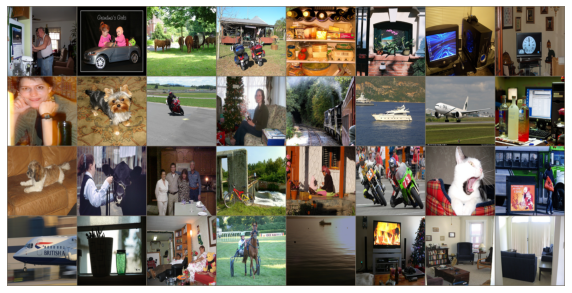

In [6]:
samples = next(iter(valid_dataloader))
inputs = samples[0]
input_grid = make_grid(inputs)

fig = plt.figure(figsize=(10, 10))
input_grid = input_grid.numpy()
input_grid = input_grid.transpose((1, 2, 0)) * imagenet_std + imagenet_mean
inp = np.clip(input_grid, 0, 1)
plt.imshow(inp)
plt.axis('off')
plt.show()

The ground-truth (segmentation map) for the image grid shown above is as below. 

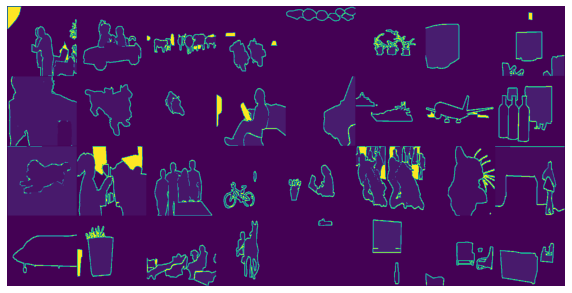

In [7]:
ground_truth = samples[1]
input_grid = make_grid(ground_truth)
inp = input_grid.numpy()[0]

fig = plt.figure(figsize=(10, 10))
plt.imshow(inp)
plt.axis('off')
plt.show()

It is worth mentioning that, as we have approached the segmentation task as an image translation problem, we take advantage of MSELoss for the training. Moreover, we believe that using the U-Net with a pre-trained encoder would help the network converge sooner and better. As this convolutional encoder is previously trained on the ImageNet, it is able to recognize low-level features (such as edge, color, etc.) and high-level features at its first and final layers, respectively.

In [8]:
# specifying loss function
criterion = nn.MSELoss()

# specifying the network
network = smp.Unet('resnet34', encoder_weights='imagenet')

# specifying optimizer
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


We can see the architecture of the ResNet-34-U-Net below. As noticed in the section above, this network is imported from the segmentation-models-pytorch library which contains many other architectures as well. You can import and use other available networks to try to increase the accuracy.

In [9]:
network

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Training deep neural networks is a challenging task, especially when we are dealing with data with big sizes or numbers. There are numerous factors and hyperparameters which play an important role in the success of the network. One of these determining factors is the number of epochs. The right number of epochs would help your network train well. However, lower and higher numbers would make your network underfit or overfit, respectively. With some data types (such as images or videos), it is very time-consuming to repeat the training for different numbers of epochs to find the best one. Poutyne library has provided some fascinating tools to address this problem. 

As you would notice in the following sections, by the use of <a href="https://poutyne.org/callbacks.html"> callbacks</a>, you would be able to record and retrieve the best parameters (weights) through your rather big number of epochs without needing to repeat the training process again and again. Moreover, Poutyne also gives you the possibility to resume your training from the last done epoch if you feel the need for even more iterations.

In [10]:
# callbacks

save_path = 'saves'

# Creating saving directory
os.makedirs(save_path, exist_ok=True)

callbacks = [
    # Save the latest weights to be able to continue the optimization at the end for more epochs.
    ModelCheckpoint(os.path.join(save_path, 'last_weights.ckpt')),
    # Save the weights in a new file when the current model is better than all previous models.
    ModelCheckpoint(
        os.path.join(save_path, 'best_weight.ckpt'),
        save_best_only=True,
        restore_best=True,
        verbose=True,
    ),
    # Save the losses for each epoch in a TSV.
    CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
]

## Training

In [11]:
# Poutyne Model on GPU
model = Model(network, optimizer, criterion, device=device)

# Train
model.fit_generator(train_dataloader, valid_dataloader, epochs=num_epochs, callbacks=callbacks)

Epoch:  1/70 Train steps: 7 Val steps: 7 5.74s loss: 0.378295 val_loss: 53.974230  
Epoch 1: val_loss improved from inf to 53.97423, saving file to saves/best_weight.ckpt
Epoch:  2/70 Train steps: 7 Val steps: 7 5.69s loss: 0.081297 val_loss: 7.162553  
Epoch 2: val_loss improved from 53.97423 to 7.16255, saving file to saves/best_weight.ckpt
Epoch:  3/70 Train steps: 7 Val steps: 7 5.67s loss: 0.058002 val_loss: 1.012362  
Epoch 3: val_loss improved from 7.16255 to 1.01236, saving file to saves/best_weight.ckpt
Epoch:  4/70 Train steps: 7 Val steps: 7 5.75s loss: 0.053281 val_loss: 0.135083  
Epoch 4: val_loss improved from 1.01236 to 0.13508, saving file to saves/best_weight.ckpt
Epoch:  5/70 Train steps: 7 Val steps: 7 5.73s loss: 0.052167 val_loss: 0.051316  
Epoch 5: val_loss improved from 0.13508 to 0.05132, saving file to saves/best_weight.ckpt
Epoch:  6/70 Train steps: 7 Val steps: 7 5.72s loss: 0.050011 val_loss: 0.047699  
Epoch 6: val_loss improved from 0.05132 to 0.04770, s

[{'epoch': 1,
  'loss': 0.37829459654657466,
  'time': 5.743251563000001,
  'val_loss': 53.974230394676816},
 {'epoch': 2,
  'loss': 0.08129651290164039,
  'time': 5.692950908,
  'val_loss': 7.162553413373204},
 {'epoch': 3,
  'loss': 0.05800169595833601,
  'time': 5.6724744929999815,
  'val_loss': 1.0123622656708033},
 {'epoch': 4,
  'loss': 0.05328050441148749,
  'time': 5.745133828000007,
  'val_loss': 0.1350832374442911},
 {'epoch': 5,
  'loss': 0.05216735647768495,
  'time': 5.731745226000044,
  'val_loss': 0.05131595933311422},
 {'epoch': 6,
  'loss': 0.0500109918843331,
  'time': 5.720073597999999,
  'val_loss': 0.04769876795195638},
 {'epoch': 7,
  'loss': 0.04882176313103671,
  'time': 5.718488277000006,
  'val_loss': 0.04658313106063386},
 {'epoch': 8,
  'loss': 0.04915147862936321,
  'time': 5.746004846999995,
  'val_loss': 0.04536136895628043},
 {'epoch': 9,
  'loss': 0.04819350771641617,
  'time': 5.736198875000014,
  'val_loss': 0.0453533968875106},
 {'epoch': 10,
  'loss

# Calculation of the scores and visualization of results

There is one more helpful feature in Poutyne, which makes the evaluation task more easy and straight forward. Usually, computer vision researchers try to evaluate their trained networks on validation/test datasets by obtaining the scores (accuracy or loss usually), ground truths, and computed results simultaneously. The `evaluate` methods in Poutyne provides you with the scores but also have made the other two items ready for further analysis and visualization. In the next few blocks of code, you will see some examples.

In [12]:
loss, predictions, ground_truth = model.evaluate_generator(valid_dataloader, return_pred=True, return_ground_truth=True)

Test steps: 7 2.15s test_loss: 0.026356                               


We show some of the segmentation results in the image below (grayscale):

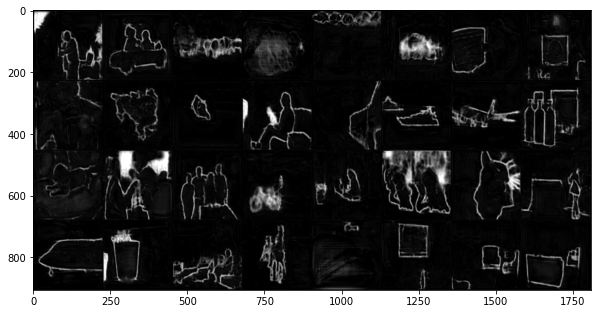

In [13]:
outputs = torch.tensor(model.predict_on_batch(inputs))
output_grid = make_grid(outputs)
out = output_grid.numpy().transpose((1, 2, 0))
out = np.clip(out, 0, 1)

fig = plt.figure(figsize=(10, 10))
plt.imshow((out))
plt.show()

Here, we show one of the input samples along with its segmentation ground truth and the produced output.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


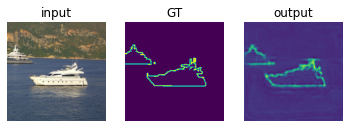

In [14]:
sample_number = 13

input_sample = inputs[sample_number].numpy().transpose((1, 2, 0)) * imagenet_std + imagenet_mean
ground_truth_sample = ground_truth[sample_number][0]
output_sample = outputs[sample_number][0].numpy()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(input_sample)
ax1.axis('off')
ax1.set_title('input')

ax2.imshow(ground_truth_sample)
ax2.axis('off')
ax2.set_title('GT')

ax3.imshow(output_sample)
ax3.axis('off')
ax3.set_title('output')
plt.show()

# Last note

This example shows you how to design and train your own segmentation network simply. However, to get better results, you can play with the hyperparameters and do further finetuning to increase the accuracy.